Training Regular ML...
Done.
Training PINN...
Done.


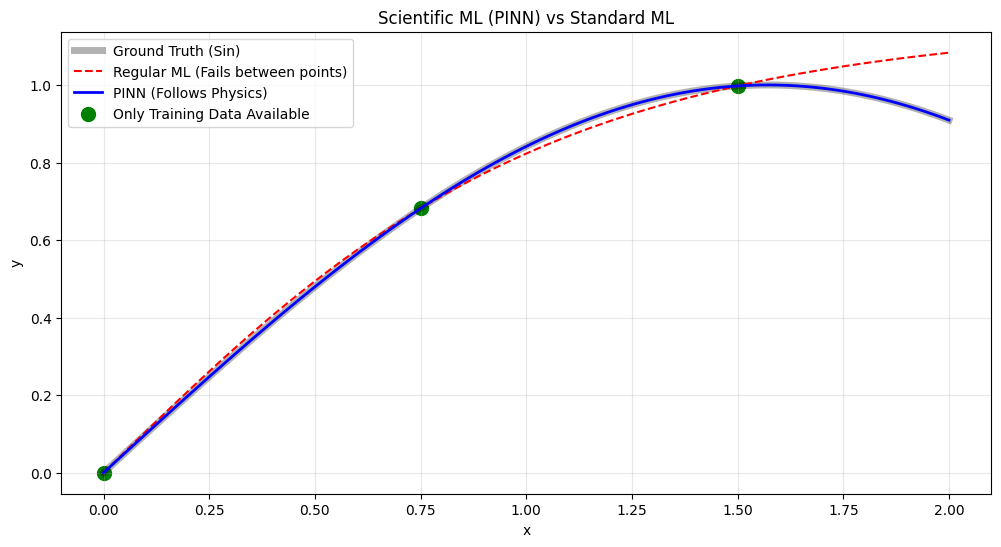

In [6]:
# %% [markdown]
# # Physics-Informed Neural Networks (PINNs) vs. Standard Neural Networks
# This notebook compares a standard MLP with a PINN by fitting a sine wave.
# The PINN uses the underlying physical law: d²y/dx² + y = 0.

# %%
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# ## 1. Define the Neural Network
# We use the same architecture for both models to ensure a fair comparison.
# We use Tanh activation because it has continuous non-zero derivatives (required for PINNs).

# %%
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 1)
        )
    def forward(self, x):
        return self.net(x)

# %% [markdown]
# ## 2. Prepare Training Data
# We provide very little data (only 3 points) to show how Regular ML struggles 
# while SciML (PINNs) uses "physics" to fill the gaps.

# %%
# Sparse training data (Regular ML only sees these)
x_train = torch.tensor([0.0, 0.75, 1.5]).view(-1, 1).requires_grad_(True)
y_train = torch.sin(x_train)

# Physics points (Collocation points) - No labels (y) needed here!
# These are points where we tell the model: "Regardless of the label, follow the law of physics."
x_physics = torch.linspace(0, 2, 30).view(-1, 1).requires_grad_(True)

# %% [markdown]
# ## 3. Train Regular Machine Learning Model
# This model only learns from the 3 green dots.

# %%
model_regular = SimpleNet()
optimizer_reg = torch.optim.Adam(model_regular.parameters(), lr=0.01)
mse_loss = nn.MSELoss()

print("Training Regular ML...")
for i in range(2000):
    optimizer_reg.zero_grad()
    y_pred = model_regular(x_train)
    loss = mse_loss(y_pred, y_train)
    loss.backward(retain_graph=True)
    optimizer_reg.step()
print("Done.")

# %% [markdown]
# ## 4. Train PINN (Scientific ML) Model
# This model learns from the 3 dots AND the second-order differential equation.

# %%
model_pinn = SimpleNet()
optimizer_pinn = torch.optim.Adam(model_pinn.parameters(), lr=0.01)

print("Training PINN...")
for i in range(2000):
    optimizer_pinn.zero_grad()
    
    # Task 1: Fit the data (MSE Loss)
    y_pred_data = model_pinn(x_train)
    loss_data = mse_loss(y_pred_data, y_train)
    
    # Task 2: Satisfy the Physics (Residual Loss)
    # We calculate derivatives of the output with respect to the input
    y_p = model_pinn(x_physics)
    
    # dy/dx
    grads = torch.autograd.grad(y_p, x_physics, torch.ones_like(y_p), create_graph=True, retain_graph=True)[0]
    # d²y/dx²
    grads2 = torch.autograd.grad(grads, x_physics, torch.ones_like(grads), create_graph=True)[0]
    
    # The ODE for a sine wave: y'' + y = 0
    loss_physics = torch.mean((grads2 + y_p)**2)
    
    # Total Loss
    total_loss = loss_data + loss_physics
    total_loss.backward(retain_graph=True)
    optimizer_pinn.step()
print("Done.")

# %% [markdown]
# ## 5. Compare Results
# Visualizing how the physics constraint helps the model generalize between data points.

# %%
x_test = torch.linspace(0, 2, 100).view(-1, 1)
with torch.no_grad():
    y_reg = model_regular(x_test)
    y_pinn = model_pinn(x_test)
    y_true = torch.sin(x_test)

plt.figure(figsize=(12, 6))
plt.plot(x_test, y_true, label="Ground Truth (Sin)", color='black', alpha=0.3, lw=5)
plt.plot(x_test, y_reg, label="Regular ML (Fails between points)", color='red', ls='--')
plt.plot(x_test, y_pinn, label="PINN (Follows Physics)", color='blue', lw=2)
plt.scatter(x_train.detach(), y_train.detach(), color='green', s=100, label="Only Training Data Available")
plt.title("Scientific ML (PINN) vs Standard ML")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()